# Generate dx,dy location perturbations to  be applied to SI3 restart file

_Last update:_ 2024-12-12

_Author_: Stephanie Leroux, Datlas.

__Goal:__ My notes to explain how to use the lu-simulator to generate location perturbation in the initial state of the Arctic-BLISS project ensemble simulations.

---

## 0. Load Python packages

In [1]:
## standart libraries
import os,sys
import sys

import numpy as np
from scipy import stats

# xarray
import xarray as xr

# plot
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from matplotlib import animation
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

from IPython.display import HTML

# for jupyter notebook display
%matplotlib inline

def Fsaveplt(fig,diro,namo,dpifig=300):
    """Save plot to file.
    
    Parameters:
    - fig: Figure properties to save.
    - diro (str): Output directory.
    - namo (str): Name of the output plot.
    - dpifig (int): Resolution (dpi) of saved plot.
    
    Returns:
    None
   """
    
    fig.savefig(diro+namo+".png", facecolor=fig.get_facecolor(),
                edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0.01)
    print(diro+namo+".png")
    plt.close(fig) 

## 1. Set up environment

* Set up and go to working directory
```bash
LUdir="/lustre/fswork/projects/rech/cli/regi915/DEVGIT/ArcticBLISS-all/lu-simulator"
workingdir=${LUdir}"/examples/"
cd ${workingdir}
```

In [2]:
%cd /lustre/fswork/projects/rech/cli/regi915/DEVGIT/ArcticBLISS-all/lu-simulator/examples/
LUdir="/lustre/fswork/projects/rech/cli/regi915/DEVGIT/ArcticBLISS-all/lu-simulator/examples/"

/lustre/fswork/projects/rech/cli/regi915/DEVGIT/ArcticBLISS-all/lu-simulator/examples


* Load python:
  Note: on Jean Zay, need to load same python install as when the ensdam software was compiled:
```bash
module unload python
module load climate_science
```

---

## 2. Link to files
* In the working directory, link files with standard names for later use:
```bash

# usual mesh_mask/grid file from NEMO (mesh_mask_NANUK4_L31_4.2.nc )                                       
ln -sf mesh_mask_NANUK4_L31_4.2.nc grid.nc 

# reference restart sea-ice file  from NEMO-SI3 to be perturbed 
ln -sf 001NANUK4_ICE_ABL-EABLBBM000_00001800_restart_ice.nc reference.nc

#  mask file for all the variables, prealably created following this tuto:
#  https://github.com/cmems-arcticbliss/lu-simulator/tree/main/misc_tools/make_rstmask
ln -sf 001NANUK4_ICE_ABL-EABLBBM000_00001800_restart_ice_mask.nc mask.nc

# text file of the list of variables to  perturb (can be prepared following same tuto as above)
vargridinfo.asc

---

## 3. Drown land (once for all for a given reference file)
Drowning here means that we fakely fill (with interpolation) the continents with non-NaN values to avoid discontinuities in the fields at the coast for later processing.


```bash
#!/bin/bash

# input file 
grid_file="grid.nc"
mask_file="mask.nc"
vargrid_file="vargridinfo.asc"
ref_file="reference.nc"

# output file
unmasked_reference="unmasked_reference.nc"

python ../src/unmask_fields.py -ref ${ref_file} -v ${vargrid_file} -mask ${mask_file} -o ${unmasked_reference}
```

* plot to illustrate the "drowned" file compared to reference:

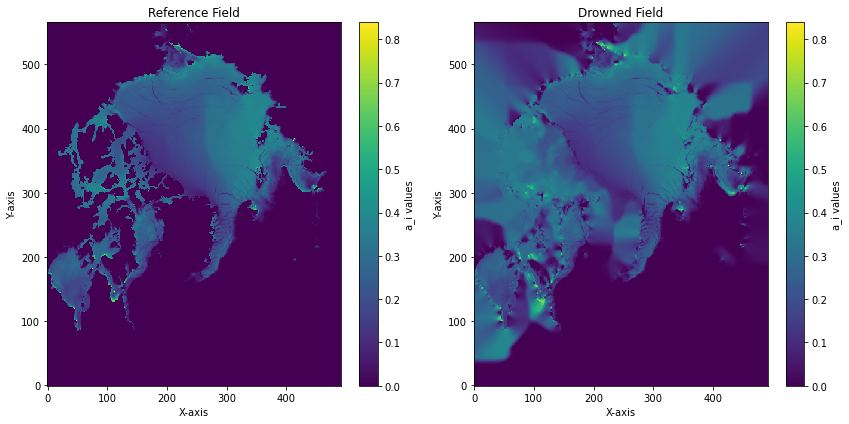

/lustre/fswork/projects/rech/cli/regi915/DEVGIT/ArcticBLISS-all/lu-simulator/examples/drowning.png


In [3]:
# Load the fields
reffield = xr.open_dataset("reference.nc", decode_times=True)
drownedfield = xr.open_dataset("unmasked_reference.nc", decode_times=True)

# Extract the data for plotting
ref_data = reffield['a_i'][0, 2, :, :]
drowned_data = drownedfield['a_i'][0, 2, :, :]

# Create a 1x2 panel plot
fig, axes = plt.subplots(1, 2, figsize=[12, 6], facecolor='w')

# Panel 1: Plot reffield data
ax = axes[0]
p1 = ref_data.plot(ax=ax, cmap="viridis", add_colorbar=False)
ax.set_title("Reference Field")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
fig.colorbar(p1, ax=ax, label="a_i values")

# Panel 2: Plot drownedfield data
ax = axes[1]
p2 = drowned_data.plot(ax=ax, cmap="viridis", add_colorbar=False)
ax.set_title("Drowned Field")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
fig.colorbar(p2, ax=ax, label="a_i values")

# Adjust layout and show
plt.tight_layout()
plt.show()
Fsaveplt(fig,LUdir,"drowning")

## 4. Create a damping file 
To avoid applying the perturbations too close to the coastline, we define a decreasing coeff (exponentional decay) from 1 (land) to 0 (where the perturbations will be fully applied) with a damping length scale of  `l`.

* the `-l` option gives the damping length `l` in grid points (distance to the coast)
* the `-s` option activates  a smoothing of the resulting damping file with s iterations of a 1-2-1 kernel if needed. This option was motivated by the fact  taht, without smoothing, some articfacts sometimes appear in the damping coeffs and then in the perturbed fields at specific location and geometry of the coast.  Some illustration of this is provided just below.
* the `-kmscaling` activate a scaling of the damping coefficient by the sinverse of the ize of the local grid cells so that when this damping coeff is used to apply the perturbation, the standard deviation of the perturbation can be set in kilometers rather than in grid points. This options need to link to the grid.nc file where the metrics of the grid can be found.

```bash
#!/bin/bash

# input parameters
lgrid=15 # length scale of the exponential decay (in grid points)
sm=4     # number of iterations of the 1-2-1 smoother

# files
vargridinfo="varlistinfo.asc"
mask="mask.nc"
grid="grid.nc"

# output file name
prefix_ofile="damping_factor"
suffix='mylabel'

python ../src/generate_damping_factor.py -l ${lgrid} -v ${vargridinfo} -mask ${mask} -s ${sm} -kmscaling grid_file  -o ${prefix_ofile}_lgrid${lgrid}_sm${sm}_${suffix}.nc


```

* Plot the damping factor without smoothing 

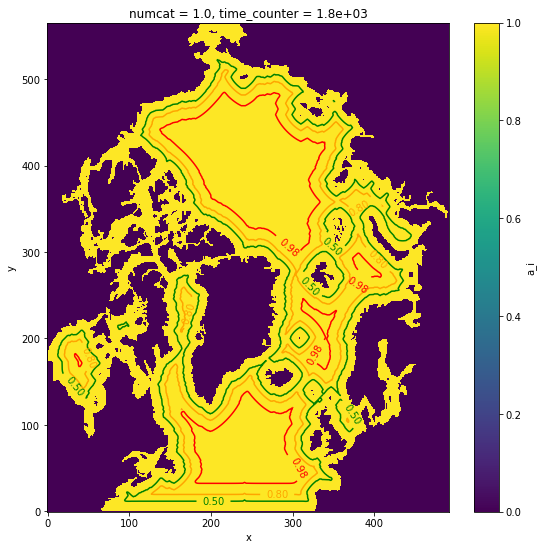

/lustre/fswork/projects/rech/cli/regi915/DEVGIT/ArcticBLISS-all/lu-simulator/examples/damping1.png


In [4]:
# Load datasets
mask = xr.open_dataset("mask.nc", decode_times=True)
damping = xr.open_dataset("damping_factor_lgrid10_sm0_SD1800.nc", decode_times=True)
grid = xr.open_dataset("grid.nc", decode_times=True)

# Compute the grid scaling factor
grid_factor = np.sqrt(0.5 * (grid["e1t"][0,:,:]**2 + grid["e2t"][0,:,:]**2))
grid_factor = grid_factor/1000. # in km

# Scale the damping coefficient
scaled_damping = damping["a_i"] * grid_factor

# Create the plot
fig1, ax = plt.subplots(1, 1, figsize=[9, 9], facecolor='w')

# Plot the mask data
mask["a_i"][0, 0, :, :].plot(ax=ax)

# Add contours for the scaled damping data
contour_levels = [ 0.5, 0.8, 0.98]
contour_colors = [ 'green', 'orange', 'red']  # One color per contour level

contour = ax.contour(
    scaled_damping[0, 0, :, :],
    levels=contour_levels,
    colors=contour_colors,  
    linewidths=1.5
)

# Add contour labels
ax.clabel(contour, inline=True, fontsize=10, fmt='%1.2f')

# Show the plot
plt.show()

Fsaveplt(fig1,LUdir,"damping1")

*  zoom on some islands to illustrate sharp unrealistic gradients at grid point scale at some locations with specific coastal geometry

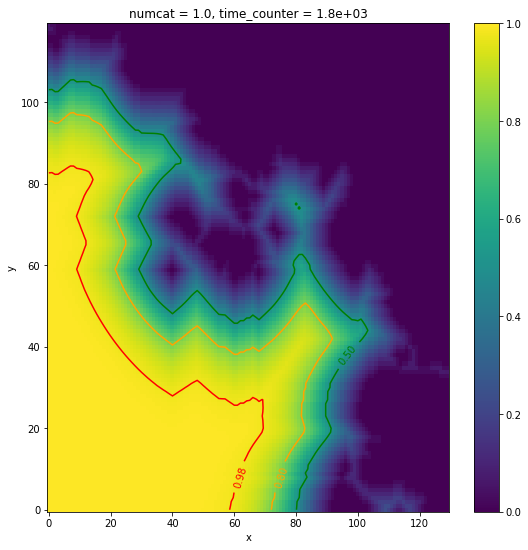

/lustre/fswork/projects/rech/cli/regi915/DEVGIT/ArcticBLISS-all/lu-simulator/examples/damping2_zoom.png


In [5]:
# Create the plot
fig1, ax = plt.subplots(1, 1, figsize=[9, 9], facecolor='w')

# Plot the mask data
scaled_damping[0,0,400:520,270:400].plot(ax=ax)

contour = ax.contour(
    scaled_damping[0,0,400:520,270:400],
    levels=contour_levels,
    colors=contour_colors,  
    linewidths=1.5
)

# Add contour labels
ax.clabel(contour, inline=True, fontsize=10, fmt='%1.2f')

# Show the plot
plt.show()
Fsaveplt(fig1,LUdir,"damping2_zoom")

* Plot the damping coefficient when a s=3  smoothing has been applied (--> mostly remove the too-sharp gradients)

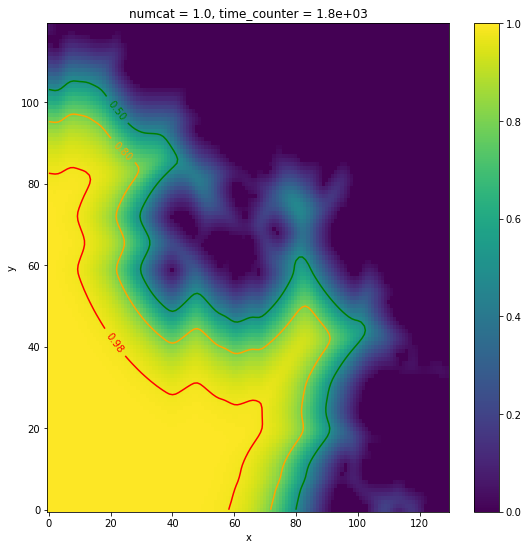

/lustre/fswork/projects/rech/cli/regi915/DEVGIT/ArcticBLISS-all/lu-simulator/examples/damping3_zoomsmoothed.png


In [6]:
# Load smoothed version
damping = xr.open_dataset("damping_factor_lgrid10_sm3_SD1800.nc", decode_times=True)

# Scale the damping coefficient
scaled_damping = damping["a_i"] * grid_factor


# Create the plot
fig1, ax = plt.subplots(1, 1, figsize=[9, 9], facecolor='w')

# Plot the mask data
scaled_damping[0,0,400:520,270:400].plot(ax=ax)

contour = ax.contour(
    scaled_damping[0,0,400:520,270:400],
    levels=contour_levels,
    colors=contour_colors,  
    linewidths=1.5
)

# Add contour labels
ax.clabel(contour, inline=True, fontsize=10, fmt='%1.2f')

# Show the plot
plt.show()

Fsaveplt(fig1,LUdir,"damping3_zoomsmoothed")

* From the zoomed plot, you can see that this setting with `lgrid=10` means that the damping coefficient is near 1 at about 35 grid points from the coastline (about 350 km). It is 0.8 at about 200 km from the coasts and falls at 0.5 at about 100 km.

---

# 5. Sample N gaussian perturbations dx,dy

* Generate  N samples of  location perturbations (dx,dy) with correlation length  `l_values` . 

```bash
#!/bin/bash

# input parameters
N=20   # number of samples to generate
l_values=(500) # correlation scale in km (if option -s is used for perturbation on the sphere)

# input file
grid_file="grid.nc"

# output file name
prefix_ofile="perturbation_sample"
perturbation_file=${prefix_ofile}"_${l}km_N${N}.nc"

# generate perturbations
python ../src/sample_perturbations.py -s  -m ${N} -l ${l} -grid ${grid_file} -o ${perturbation_file}

done
```

* With the above script we have generated 20 samples of perturbation fields at the required horizontal correlation length scale set in km here (500 km).
* Let's plot those fields and check that for a given location, the perturbation dx,dy is an isotropic normal random vector with a standard deviation of 1.

In [7]:
pert =  xr.open_dataset("perturbation_sample_500km_N20.nc",decode_times=True)

* Plot those N perturbations 

In [8]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from IPython.display import HTML

# Number of timesteps in the output file
N = pert.member.size

# select colormap and set gray color for missing values (i.e. for land)
cmap = cm.Spectral_r

# select sea ice height
data2plt = pert.dx

fig, ax = plt.subplots(1, 1, figsize=[8, 8], facecolor='w')

# plot the initial frame
ie = 0
p = ax.pcolormesh(data2plt.isel(member=ie).values, vmin=-2.5, vmax=2.5, cmap=cmap)

# add date (create annotation that will be updated)
d = ax.text(10, 520, "Mb " + str(ie), fontsize=14, color="k", backgroundcolor='white')

# add colorbar
plt.colorbar(p, label='perturbation', extend='both')


# Animation function
def animate(ie):
    # Update the pcolormesh with new data
    p.set_array(data2plt.isel(member=ie).values.flatten())  # Flatten the 2D array for pcolormesh
    
    # Update the annotation text
    d.set_text("Mb " + str(ie))
    
    return p, d


# Initialization function
def init():
    # Initialize the pcolormesh for the first frame
    p.set_array(data2plt.isel(member=0).values.flatten())
    
    # Initialize the annotation
    d.set_text("Mb 0")
    
    return p, d


# Create the animation
ani = animation.FuncAnimation(fig=fig,
                              func=animate,
                              frames=N,
                              init_func=init,
                              interval=300,
                              blit=True)

# Close the figure after creating the animation to prevent showing the last plot
plt.close(fig)

# Show the animation
HTML(ani.to_jshtml())


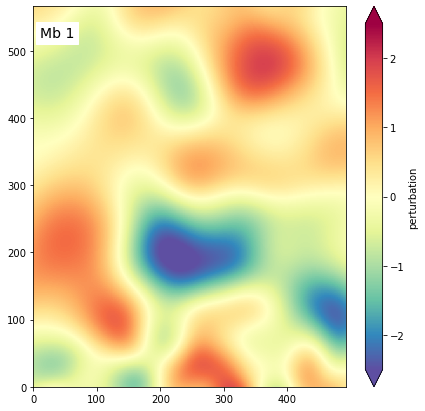

/lustre/fswork/projects/rech/cli/regi915/DEVGIT/ArcticBLISS-all/lu-simulator/examples/pert_MB1.png


In [9]:
# plot the initial frame
ie = 0
for ie in np.arange(0,1):
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=[7, 7], facecolor='w')

    p = ax.pcolormesh(data2plt.isel(member=ie).values, vmin=-2.5, vmax=2.5, cmap=cmap)

    # add date (create annotation that will be updated)
    d = ax.text(10, 520, "Mb " + str(ie+1), fontsize=14, color="k", backgroundcolor='white')

    # add colorbar
    plt.colorbar(p, label='perturbation', extend='both')


    # Show the plot
    plt.show()

    Fsaveplt(fig,LUdir,"pert_MB"+str(ie+1))
    #plt.close(fig1)

* Now we can check the local Standard deviation (Std) across members. Should be around 1 hopefully if N is large enough. If the perturbation follows a normal law in each location, the sample std for N=100 should be 1 with an error of about 7% (Relative_error=$\sigma/\sqrt{ 2N}$).

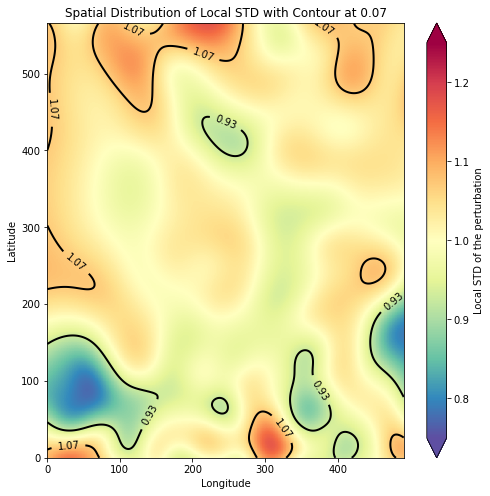

/lustre/fswork/projects/rech/cli/regi915/DEVGIT/ArcticBLISS-all/lu-simulator/examples/CheckLocalSTD.png


In [5]:
# load perturbation file for which 100 sampled were generated
pert100 =  xr.open_dataset("./old/perturbation_sample_500km_N100.nc",decode_times=True)
N=100
# select colormap 
cmap = cm.Spectral_r

# select variable to plot (perturbation in x direction)
data2plt = pert100.dx

# Compute the local standard deviation across the ensemble members
std_data = data2plt.std(dim='member').values

# create fig
fig, ax = plt.subplots(1, 1, figsize=[8, 8], facecolor='w')

# Plot the standard deviation data using pcolormesh
p = ax.pcolormesh(std_data, vmin=0.75, vmax=1.25, cmap=cmap)

# Add colorbar
plt.colorbar(p, label='Local STD of the perturbation', extend='both')

# Add a contour line where the standard deviation is err
err = round(1/np.sqrt(2*N),2)
contour = ax.contour(std_data, levels=[1-err,1+err], colors='black', linewidths=2)

# Add labels to the contour line
ax.clabel(contour, fmt="%.2f", inline=True, fontsize=10)

# Add optional title and labels
ax.set_title("Spatial Distribution of Local STD with Contour at 0.07")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()
plt.close(fig)

Fsaveplt(fig,LUdir,"CheckLocalSTD")


In [72]:
data2plt.std(dim='member').max()

<xarray.DataArray 'dx' ()>
array(1.17673506)

__--> The dx,dy location perturbations have been generated  and now need to be applied to the sea ice fields of the NEMO-SI3 restart file, with a Standard Deviation set to a choosen value in kilometer. This will be explained and illustrated  in the next notebook.__